# Case study : measuring, identifying and counting shapes

This case study will be carried out in Python3, using the [scikit-image](http://scikit-image.org/docs/stable/) library and or [opencv](https://docs.opencv.org/4.x/) library. The arrays (`ndarray`) used by these libraries to manipulate images come from the [numpy](https://docs.scipy.org/doc/) library. Images and other figures are displayed using [matplotlib](https://matplotlib.org/contents.html). The documentation for these four libraries will come in very handy.

In this case study, questions will be indicated in a **question** block, and answers will be given in the **answer** block below the question block or in a code block. Your answers should be written in [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). This will allow you to answer not only with text, but also with tables and images.

:::{important}
Since this is a case study, you will be much less guided that during the previous labs. Its is usually up to you to decide which method to use to solve the given questions. You should not only use code blocks, but you should also add markdown block in order to explain what you are doing and justify your choices
:::

*This project is based on an existing project proposed by prof. Harold Mouchère at Nantes Université IUT.*

The code cell below provides a few imports that are useful as a starting point. If you add additional dependencies don't forget to add them here so that we can reproduce your results easily.

In [ ]:
%pip install -q scikit-image opencv-python ipywidgets==8.1.1 matplotlib ipympl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import cv2 as cv
from skimage import io, util, filters, color, feature, transform, morphology, exposure, measure

```{figure} lego/lego_0.jpg
:alt: Lego 10
:height: 200px
:class: float-right
```

## Step 1 : (simple) lengths measurement

In the images of LEGO pieces `lego_0.jpg` to `lego_8.jpg`, the bars are 3 to 12 units long. All the images were taken with the same camera, at the same distance and with the same resolution. We're going to try to measure the length of the bars. For this first step, they all have the same orientation (horizontal) but are not all the same color.
1. Make a function that takes an image as parameter and returns the rectangle enclosing the bar. Draw the rectangle on the image.
    - Hint : first test on image `lego_1.jpg` it is easier to process than `lego_0.jpg`
3. Next, we'll calibrate our measurement. Knowing that the size of the bar in the image `lego_8.jpg` is 12, find the pixel value of one unit. 
4. Using the size of their bounding box, find the length of each bar (of images `lego_0.jpg` to `lego_8.jpg`) in units and pixels. Display the lengths in units and pixels. Is your algorithm working correctly on all images ? If not, try to improve it and explain the modifications made.

In [ ]:
def measureBar( image ):
    xmin=xmax=ymin=ymax=1

    # show the image histogram, can help finding a threshold at first...
    plt.figure()
    plt.hist(image.flatten(), bins=256)
    _, new_image  = cv.threshold(image, 130, 255, cv.THRESH_BINARY_INV)
    plt.figure()
    plt.imshow(new_image, cmap='gray')

    nonzero = new_image.nonzero()
    
    xmin = np.min(nonzero[1])
    xmax = np.max(nonzero[1])
    ymin = np.min(nonzero[0])
    ymax = np.max(nonzero[0])

    return xmin, xmax, ymin, ymax

# in a first step, let's loop on a single image
# then you'll have to work on the first 9 image
for img_num in range(0,9):
    filename = f'lego/lego_{img_num}.jpg'
    print(f'\nMeasuring {filename}')
    image=io.imread(filename)
    # in a first step will only process the image as greyscale
    image=color.rgb2gray(image)*255
    
    xmin, xmax, ymin, ymax = measureBar(image)

    pixel_to_unit = 60 # You'll have to change that

    print('bar size (pixels):', xmax-xmin)
    print('bar size (units):', round((xmax-xmin)/pixel_to_unit))

    # show the image with bounding box in red
    plt.figure()
    plt.imshow(image, cmap='grey')
    rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="red", alpha=0.9, fill=False, linewidth=0.5)
    ax = plt.gca()
    ax.add_patch(rect)

    # or show only the bounding box
    plt.figure()
    plt.imshow(image[ymin-10:ymax+11,xmin-10:xmax+11], cmap='grey')

## Step 2 : measuring bars of any orientation

In this exercise, we'll look at another way of measuring bar lengths. We'll be looking at the length of the bar contour. In fact, the contour is equal to $2 * length + 2 * thickness$. 

First you'll design an algorithm based on the image `lego_1.jpg` , then you'll make a function that will **return the size (in unit) of the bar passed in parameter**. Finally, you'll test your solution on different images `lego_0.jpg` to `lego_8.jpg`. 

### 1. Algorithm design

Based on the various filters and segmentation methods seen in the different labs of this course, propose a series of processes to obtain a black image where the part's outline pixels are white. Like in the previous step, you will recover the bounding rectangle of these outline pixels to display just the part and its outline (with a small margin of 10 pixels) as shown below.


![](pieceEtContour.png)

Then simply count the white pixels with `np.sum(...)`, for example, for the image `lego_1.jpg` there are approximately 530 outline pixels. From this measure you'll have to calculate the real bar length (in units). For example for `lego_1.jpg` the 530 outline pixels correspond to a bar of 4 units.

### 2. Create a function

Take your algorithm and turn it into a function that displays the contour of the object found, **returning the size (in unit) of the bar** (like in step 1).

In [ ]:
def measure_bar( image ):
    gaussian = np.ones((5,5), np.float32)/25
    new_image = cv.filter2D(image, -1, gaussian)
    new_image = (new_image.astype(np.int16) * (50/127+1) - 50 + 50).clip(0, 255).astype(np.uint8)

    plt.figure()
    plt.imshow(new_image, cmap='gray')
    plt.show()

    _, new_image  = cv.threshold(new_image, 215, 255, cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15))
    new_image = cv.morphologyEx(new_image,cv.MORPH_OPEN,kernel)
    new_image = cv.bitwise_not(new_image)

    plt.figure()
    plt.imshow(new_image, cmap='gray')
    plt.show()

    contours, hierarchy = cv.findContours(new_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    c_image = np.full_like(new_image, 0)
    c_image = cv.drawContours(c_image, contours, -1, (255,255,255), 1)

    plt.figure()
    plt.imshow(c_image, cmap='gray')
    plt.show()

    maxlength = 0
    largest_contour = None
    for cnt in contours:
        length = cv.arcLength(cnt, True)
        if length > maxlength:
            maxlength = length
            largest_contour = cnt

    print(round(maxlength/130))

### 3. Testing 

Test your algorithm on the 8 bar images `lego_1.jpg` to `lego_8.jpg`. Is your algorithm robust to all situations ? What are the limitations ? Can you improve it ? 
To go further, test your function on all the possible bars in images `lego_9.jpg` to `lego_11.jpg`. To isolate the bars, you can use manual image cropping with pixel intervals (see below).

In [ ]:
for img_num in range(0,9):
    filename = f'lego/lego_{img_num}.jpg'
    print(f'\nMeasuring {filename}')
    image=io.imread(filename)
    image=color.rgb2gray(image)*255
    image = image[600:image.shape[0]-1,0:image.shape[1]-1]
    measure_bar(image)

In [ ]:
# This example just shows each bar of each image
# Please add you code in order to measure the length of each bar of each image
lego_coords = {
            9: [((150,900),(150,600)), ((100,500),(700,1100)), ((600,900),(950,1100))],
            10: [((200,500),(200,800)), ((500,900),(250,500)), ((0,550),(800,1450)), ((550,750),(600,1250))],
            11: [((0,450),(600,800)), ((500,750),(400,800)), ((300,750),(850,1200)), ((650,800),(1000,1300))]
        }
# just for fun, display the fist bar of image 9
for cpt in range(9,12):
    image=io.imread(f'lego/lego_{cpt}.jpg')
    image = color.rgb2gray(image)*255
    for l in range(len(lego_coords[cpt])):
        # crop
        bar_coords = lego_coords[cpt][l]
        rect = plt.Rectangle((bar_coords[0][0], bar_coords[1][0]), bar_coords[0][1]-bar_coords[0][0], bar_coords[1][1]-bar_coords[1][0],
                         edgecolor="red", alpha=0.9, fill=False, linewidth=0.5)
        ax = plt.gca()
        ax.add_patch(rect)
        # then crop it
        img_B1 = image[bar_coords[1][0]:bar_coords[1][1],bar_coords[0][0]:bar_coords[0][1]]
        plt.imshow(image, cmap='gray')
        plt.title(f'lego_{cpt}.jpg bar {l+1}')
        plt.show()
        plt.imshow(img_B1, cmap='gray')
        plt.show()
        # here you can call your measureBar function
        img_B1 = img_B1.astype(np.uint8)
        measure_bar(img_B1)

## Step 3: counting objects

In this part, we'll look at how to use morphological operations to count objects in an image. 

```{figure} lego/lego_10.jpg
:alt: Lego 10
:height: 200px
:class: float-right
```
### 1. Black and gray bars

First, design an algorithm based on image `lego_9.jpg`, then test it on images `lego_10.jpg` and `lego_11.jpg`. Convert the images to grayscale for easier processing. Then binarize the images to keep only the pixels belonging to the lego bars. Use morphological operations to remove isolated pixels, then count the remaining objects by counting the number of connected components. You can filter connected components by size to keep only the lego bars.

In [ ]:
for cpt in range(9,12):
    image=io.imread(f'lego/lego_{cpt}.jpg')
    image = color.rgb2gray(image)*255
    image = image[200:image.shape[0]-1,0:image.shape[1]-1]

    gaussian = np.ones((5,5), np.float32)/25
    new_image = cv.filter2D(image, -1, gaussian)
    new_image = (new_image.astype(np.int16) * (50/127+1) - 50 + 50).clip(0, 255).astype(np.uint8)

    _, new_image  = cv.threshold(new_image, 215, 255, cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15))
    new_image = cv.morphologyEx(new_image,cv.MORPH_OPEN,kernel)
    new_image = cv.bitwise_not(new_image)

    plt.figure()
    plt.imshow(new_image, cmap='gray')
    plt.show()

    num_labels, labels = cv.connectedComponents(new_image)
    hue = np.uint8(179*labels/np.max(labels))

    plt.figure()
    plt.imshow(hue, cmap='gray')
    plt.show()

    print(num_labels-1) # Background counts as a label

```{figure} lego/lego_12.jpg
:alt: Lego 12
:height: 200px
:class: float-right
```
### 2. Color shapes

Use the same kind of algorithm for the images `lego_12.jpg` to `lego_15.jpg`. You'll start by focusing on counting the red and yellow parts in images `lego_12.jpg` and `lego_13.jpg`. Then you'll look at the objects in images `lego_14.jpg` and `lego_15.jpg`. Provide the number of pieces of each color (ex: 2 red pieces and 2 yellow pieces). Does it work well for every colors ?

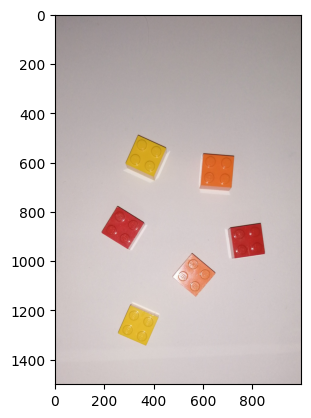

number of red blocks: 2


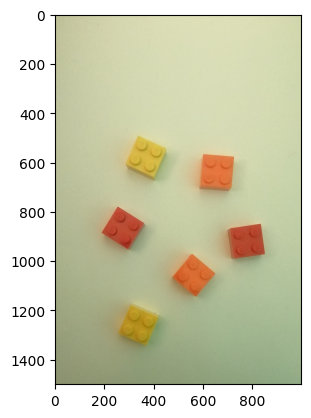

number of red blocks: 8


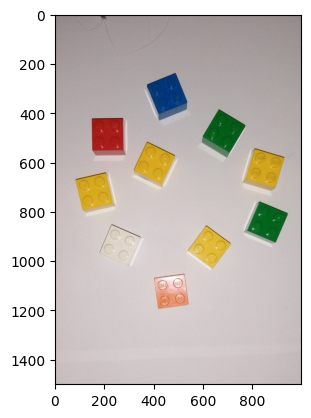

number of red blocks: 2


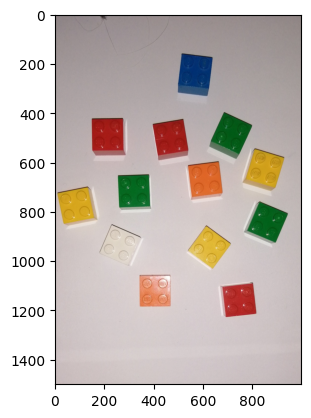

number of red blocks: 4


In [88]:
for cpt in range(12, 16):
    image=io.imread(f'lego/lego_{cpt}.jpg')

    plt.figure()
    plt.imshow(image)
    plt.show()

    image_one_channel = image[:, :, 1]
    gaussian = np.ones((5,5), np.float32)/25
    new_image = cv.filter2D(image_one_channel, -1, gaussian)
    new_image = (new_image.astype(np.int16) * (50/127+1) - 50 + 50).clip(0, 255).astype(np.uint8)
    _, new_image  = cv.threshold(new_image, 90, 255, cv.THRESH_BINARY_INV)

    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(new_image, connectivity=8)
    sizes = stats[:, cv.CC_STAT_AREA]
    res = np.where(sizes[labels] >= 300, labels, 0)
    hue = np.uint8(200*res/np.max(res))

    print("number of red blocks:", len(np.unique(res))-1)

```{figure} lego/lego_16.jpg
:alt: Lego 16
:height: 200px
:class: float-right
```
### 3. Circles and squares

In the images `lego_16.jpg` to `lego_18.jpg` you'll count the circular and square pieces. First, you'll propose an algorithm for cutting the pieces, whatever their color and shape. Then you'll need to distinguish between round and square pieces so you can count them. You can use different kinds of shape descriptors for that.

```{figure} lego/lego_19.jpg
:alt: Lego 19
:height: 200px
:class: float-right
```
### 4. Multiple shapes and multiple colors

Images `lego_19.jpg` to `lego_23.jpg` contain a large number of circular and squared objects in a variety of colors. Propose an algorithm to count the objects of a given a color and shape. Then, as a bonus, propose a second algorithm that tries to detect the number of color and shapes and then counts the number of objects of each kind.